In [1]:
%load_ext autoreload
%autoreload 2
%aimport pareto
from pareto import *
from functools import partial

In [2]:
titles = [
  'Weighted Sum, Concave Pareto Front',
  'Weighted Sum, Convex Pareto Front',
  'Lagrangian, Concave Pareto Front',
  'Lagrangian, Convex Pareto Front',
  'Augmented Lagrangian, Concave Pareto Front',
  'Augmented Lagrangian, Convex Pareto Front'
]

In [3]:
INIT_POINT = (0.1, 1.7)


In [12]:
def get_paths_for_sum(loss, steps=3000):
  loss_vec = jax.jit(jax.vmap(loss, in_axes=[0,0]))

  def _loss(x, y, alpha):
    loss_1, loss_2 = loss(x, y)
    return alpha*loss_1 + (1-alpha)*loss_2

  loss_grad = jax.jit(jax.grad(_loss, argnums=[0,1]))

  def compute_next(x, y, alpha):
    dx, dy = loss_grad(x, y, alpha)
    x = x - 0.02 * dx
    y = y - 0.02 * dy
    return x, y

  compute_next_vec = jax.jit(jax.vmap(compute_next, in_axes=[0,0,0]))

  xs, ys = np.array([INIT_POINT for _ in ALPHAS]).T
  pathsx = [xs]
  pathsy = [ys]
  for gradient_step in range(steps):
    xs, ys = compute_next_vec(xs, ys, ALPHAS)
    pathsx.append(xs)
    pathsy.append(ys)
  pathsx = np.array(pathsx[0::20]).T
  pathsy = np.array(pathsy[0::20]).T
  
  print(pathsy)
  return np.stack(loss_vec(pathsx, pathsy), 1)

In [13]:
def get_paths_for_lagrangian(loss, steps=3000):
  loss_vec = jax.jit(jax.vmap(loss, in_axes=[0,0]))

  def _loss(x, y, lam, alpha):
    eps = 0.2 + (1.9 - 0.2)*alpha
    
    loss_1, loss_2 = loss(x, y)
    
    return loss_1 + lam * (loss_2-eps)

  loss_grad = jax.jit(jax.grad(_loss, argnums=[0, 1, 2]))

  def compute_next(x, y, lam, alpha):
    dx, dy, dl = loss_grad(x, y, lam, alpha)
    x = x - 0.02 * dx
    y = y - 0.02 * dy
    lam = lam + 0.05*dl
    lam = np.where(lam < 0, 0., lam)
    return x, y, lam

  compute_next_vec = jax.jit(jax.vmap(compute_next, in_axes=[0,0,0,0]))

  X, Y = INIT_POINT
  xs, ys, lams = np.array([(X, Y, 0.) for _ in ALPHAS]).T


  pathsx = [xs]
  pathsy = [ys]
  for gradient_step in range(steps):
    xs, ys, lams = compute_next_vec(xs, ys, lams, ALPHAS)
    pathsx.append(xs)
    pathsy.append(ys)
  pathsx = np.array(pathsx[0::20]).T
  pathsy = np.array(pathsy[0::20]).T
  
  return np.stack(loss_vec(pathsx, pathsy), 1)

In [14]:
def get_paths_for_augmented_lagrangian(loss, steps=3000):
  loss_vec = jax.jit(jax.vmap(loss, in_axes=[0,0]))

  def _loss(x, y, lam, alpha):
    eps = 0.2 + (1.9 - 0.2)*alpha    
    loss_1, loss_2 = loss(x, y)
    damp = 10 * jax.lax.stop_gradient(eps - loss_2)
    
    return loss_1 + (lam - damp) * (loss_2-eps)

  loss_grad = jax.jit(jax.grad(_loss, argnums=[0, 1, 2]))

  def compute_next(x, y, lam, alpha):
    dx, dy, dl = loss_grad(x, y, lam, alpha)
    x = x - 0.02 * dx
    y = y - 0.02 * dy
    lam = lam + 0.05*dl
    lam = np.where(lam < 0, 0., lam)
    return x, y, lam

  compute_next_vec = jax.jit(jax.vmap(compute_next, in_axes=[0,0,0,0]))

  X, Y = INIT_POINT
  xs, ys, lams = np.array([(X, Y, 0.) for _ in ALPHAS]).T


  pathsx = [xs]
  pathsy = [ys]
  for gradient_step in range(steps):
    xs, ys, lams = compute_next_vec(xs, ys, lams, ALPHAS)
    pathsx.append(xs)
    pathsy.append(ys)
  pathsx = np.array(pathsx[0::20]).T
  pathsy = np.array(pathsy[0::20]).T
  
  return np.stack(loss_vec(pathsx, pathsy), 1)

In [23]:
x, y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))

In [27]:
loss_vec = jax.jit(jax.vmap(loss_concave, in_axes=[0,0]))

In [34]:
(a + b).shape

(31, 31)

[[1.7000000e+00 1.1225712e+00 8.1842548e-01 ... 4.7742487e-12
  4.0618650e-12 3.4559376e-12]
 [1.7000000e+00 1.1180679e+00 8.0803543e-01 ... 6.6866583e-01
  6.6866583e-01 6.6866583e-01]
 [1.7000000e+00 1.1183767e+00 8.0809081e-01 ... 6.6866583e-01
  6.6866583e-01 6.6866583e-01]
 ...
 [1.7000000e+00 1.1219853e+00 8.0997491e-01 ... 6.6866583e-01
  6.6866583e-01 6.6866583e-01]
 [1.7000000e+00 1.1268575e+00 8.1508803e-01 ... 6.6866583e-01
  6.6866583e-01 6.6866583e-01]
 [1.7000000e+00 1.1436654e+00 8.3838499e-01 ... 3.2535814e-12
  2.7684059e-12 2.3556823e-12]]
[[1.7000000e+00 1.0955325e+00 7.2775656e-01 ... 1.2619831e-12
  1.0752805e-12 9.1621936e-13]
 [1.7000000e+00 1.0872759e+00 7.0092422e-01 ... 6.3122342e-25
  4.3467483e-25 2.9932701e-25]
 [1.7000000e+00 1.0870136e+00 6.9656807e-01 ... 4.6246913e-28
  3.0176684e-28 1.9690663e-28]
 ...
 [1.7000000e+00 1.0942171e+00 7.0533639e-01 ... 5.0811087e-28
  3.3154874e-28 2.1633973e-28]
 [1.7000000e+00 1.1017472e+00 7.1873116e-01 ... 7.6309385e-

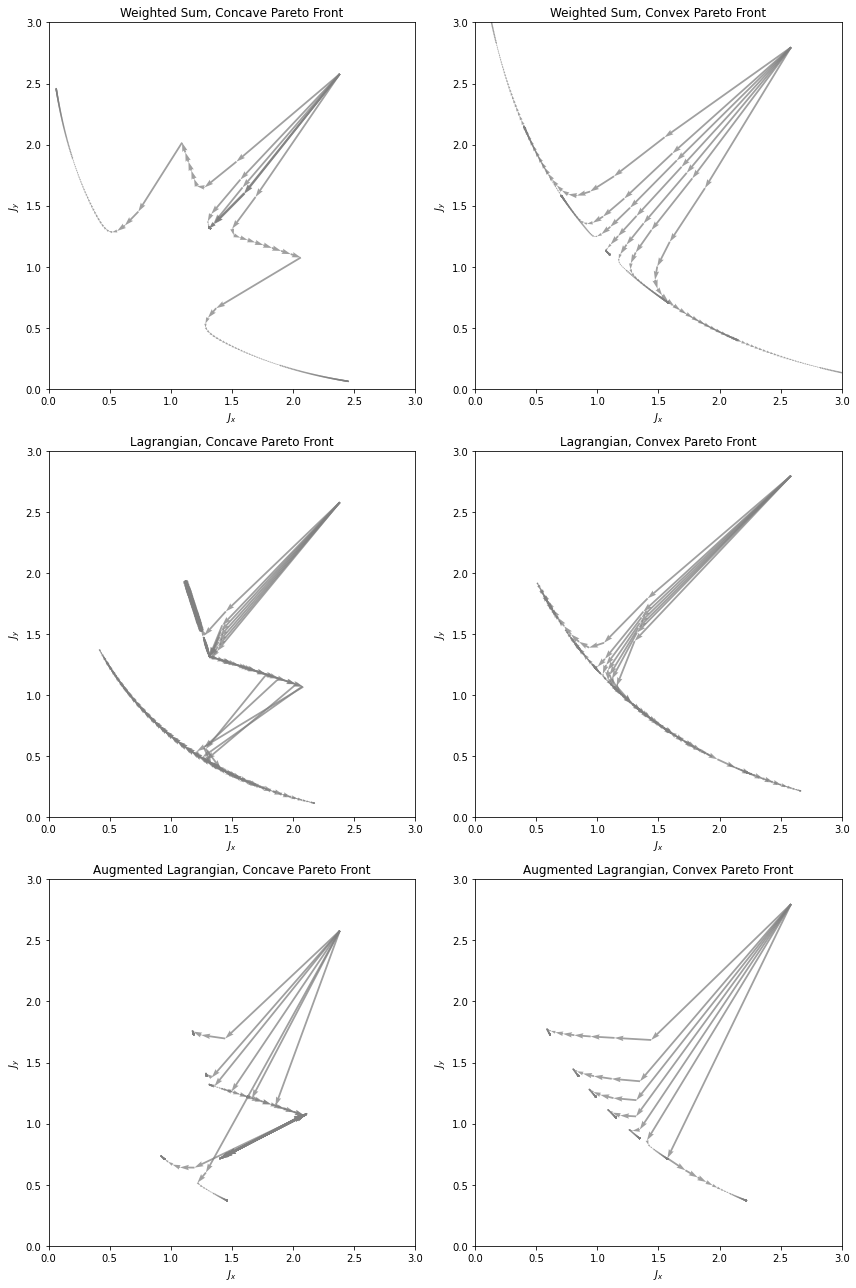

In [18]:
fig, anim = plot_paths([
  get_paths_for_sum(loss_concave), 
  get_paths_for_sum(loss_convex),
  get_paths_for_lagrangian(loss_concave), 
  get_paths_for_lagrangian(loss_convex),
  get_paths_for_augmented_lagrangian(loss_concave), 
  get_paths_for_augmented_lagrangian(loss_convex)
  ], titles = titles)

In [19]:
HTML(anim.to_html5_video())